# Creating a playing cards dataset
This notebook is a guide through the creation of a dataset of playing cards. The cards are labeled with their name (ex: "2c" for "2 of spades", "Kh" for King for hearts) and with the bounding boxes delimiting their printed corners.
> _Why bounding boxes around the corners, and not around the whole card ?_<br>Because in real conditions, more often than not, cards are partially covered. And the corner of a card is the minimum information you need to identify it.

This dataset can be used for the training of a neural net intended to detect/localize playing cards. It was used on the project __[Playing card detection with YOLO v3](https://youtu.be/pnntrewH0xg)__

<img src="img/ex_generated_image.png" alt="Example of generated image "  title="Example of generated image " />


# Prerequisites 

### A. In addition to opencv and numpy, you need the following python packages :
1. **imgaug** : https://github.com/aleju/imgaug 
> Helps with image augmentation
2. **shapely** : https://github.com/Toblerity/Shapely
> For the manipulation and analysis of geometric objects in the Cartesian plane. It is useful here when we want to check if the bounding box of a card corner is covered by another card
3. **tqdm** : https://github.com/tqdm/tqdm
> A progress bar tool. Not mandatory but convenient when you generate thousands of images

### B. Get the Describable Textures Dataset (DTD)
> A collection of textural images in the wild (https://www.robots.ox.ac.uk/~vgg/data/dtd/). It is probably not its original goal, but it is used here as an easy way to generate various backgrounds for our images.

### C. A real deck of cards
> This the only physical "data" you need. You have to make some measurements on the cards, and to take a picture/shoot a movie of each of the 52 cards of the deck. Everything else will be generated by scripts.


#### C.1 Measurements on the cards
Use a ruler to measure the dimensions as indicated in the image below. 
For the corner* measures, the idea is to delimit one rectangular zone that can hold every value+suit. The size of the marks may vary with the value or the suit, so take the measures on the cards with the widest, the tallest symbols, and add one or two millimeters. 
<img src="img/measures.png" alt="Measures" title="" />
Report the measures in mm in the cell below (and don't forget to run the cell).

In [1]:
cardW=58
cardH=88
cornerXmin=1.5
cornerXmax=10
cornerYmin=2.5
cornerYmax=20.5

# We convert the measures from mm to pixels: multiply by an arbitrary factor 'zoom'
# You shouldn't need to change this
zoom=4
cardW*=zoom
cardH*=zoom
cornerXmin=int(cornerXmin*zoom)
cornerXmax=int(cornerXmax*zoom)
cornerYmin=int(cornerYmin*zoom)
cornerYmax=int(cornerYmax*zoom)

#### C.2 Shoot one video per card
That's what I did in the project "Playing card detection with YOLO v3", and the scripts in this notebook were written to deal with videos. A video is interesting only if you can vary the brightness and color temperature of the light during the shot. Watch [Playing card detection with YOLO v3](https://www.youtube.com/watch?v=pnntrewH0xg&t=4m10s) to have an idea. 
With hindsight, I am confident that you could use one picture per card instead of a video without affecting the efficiency of the neural net. The scripts could be easily adapted to deal with pictures.
Whether you use videos or pictures, the scene must be simple, with a uniform background behind the card, like below. This way, the extraction of the card from the scene will be easy.
<img src="test/scene.png" alt="Scene" title="Scene" />

## Imports

In [2]:
import numpy as np
import cv2
import os
from tqdm import tqdm
import random
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pickle
from glob import glob 
import imgaug as ia
from imgaug import augmenters as iaa
from shapely.geometry import Polygon


## Some convenient functions used in this notebook

In [3]:
def display_img(img,polygons=[],channels="bgr",size=9):
    """
        Function to display an inline image, and draw optional polygons (bounding boxes, convex hulls) on it.
        Use the param 'channels' to specify the order of the channels ("bgr" for an image coming from OpenCV world)
    """
    if not isinstance(polygons,list):
        polygons=[polygons]    
    if channels=="bgr": # bgr (cv2 image)
        nb_channels=img.shape[2]
        if nb_channels==4:
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
        else:
            img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)    
    fig,ax=plt.subplots(figsize=(size,size))
    ax.set_facecolor((0,0,0))
    ax.imshow(img)
    for polygon in polygons:
        # An polygon has either shape (n,2), 
        # either (n,1,2) if it is a cv2 contour (like convex hull).
        # In the latter case, reshape in (n,2)
        if len(polygon.shape)==3:
            polygon=polygon.reshape(-1,2)
        patch=patches.Polygon(polygon,linewidth=1,edgecolor='g',facecolor='none')
        ax.add_patch(patch)

def give_me_filename(dirname, suffixes, prefix=""):
    """
        Function that returns a filename or a list of filenames in directory 'dirname'
        that does not exist yet. If 'suffixes' is a list, one filename per suffix in 'suffixes':
        filename = dirname + "/" + prefix + random number + "." + suffix
        Same random number for all the file name
        Ex: 
        > give_me_filename("dir","jpg", prefix="prefix")
        'dir/prefix408290659.jpg'
        > give_me_filename("dir",["jpg","xml"])
        ['dir/877739594.jpg', 'dir/877739594.xml']        
    """
    if not isinstance(suffixes, list):
        suffixes=[suffixes]
    
    suffixes=[p if p[0]=='.' else '.'+p for p in suffixes]
          
    while True:
        bname="%09d"%random.randint(0,999999999)
        fnames=[]
        for suffix in suffixes:
            fname=os.path.join(dirname,prefix+bname+suffix)
            if not os.path.isfile(fname):
                fnames.append(fname)
                
        if len(fnames) == len(suffixes): break
    
    if len(fnames)==1:
        return fnames[0]
    else:
        return fnames

# Define global variables

In [4]:
data_dir="data" # Directory that will contain all kinds of data (the data we download and the data we generate)

if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

cards_values = ["2c","2s","4d","5d","5h","6s","7h","8c","8d","9h","10c","10s"]    

# Pickle file containing the background images from the DTD
backgrounds_pck_fn=data_dir+"/backgrounds.pck"

# Pickle file containing the card images
cards_pck_fn=data_dir+"/cards.pck"


# imgW,imgH: dimensions of the generated dataset images 
imgW=720
imgH=720


refCard=np.array([[0,0],[cardW,0],[cardW,cardH],[0,cardH]],dtype=np.float32)
refCardRot=np.array([[cardW,0],[cardW,cardH],[0,cardH],[0,0]],dtype=np.float32)
refCornerHL=np.array([[cornerXmin,cornerYmin],[cornerXmax,cornerYmin],[cornerXmax,cornerYmax],[cornerXmin,cornerYmax]],dtype=np.float32)
refCornerLR=np.array([[cardW-cornerXmax,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmax],[cardW-cornerXmin,cardH-cornerYmin],[cardW-cornerXmax,cardH-cornerYmin]],dtype=np.float32)
refCorners=np.array([refCornerHL,refCornerLR])


# Get Describable Textures Dataset (DTD)
A convenient way to generate backgrounds for the images of the cards dataset

### Download DTD (1x)

In [6]:
!wget https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz

'wget' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


### Extract the DTD (1x)

In [8]:
!tar xf dtd-r1.0.1.tar.gz

### Load all *jpg from dtd subdirectories and save them in a pickle file (1x)

The next times, we will directly load the pickle file 

In [5]:
dtd_dir="dtd/images/"
bg_images=[]
for subdir in glob(dtd_dir+"/*"):
    for f in glob(subdir+"/*.jpg"):
        bg_images.append(mpimg.imread(f))
print("Nb of images loaded :",len(bg_images))
print("Saved in :",backgrounds_pck_fn)
pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

Nb of images loaded : 0
Saved in : data/backgrounds.pck


### Load all *png from personal background into a pickle file


In [6]:
dtd_dir="data/backgrounds"
bg_images=[]
for f in glob(dtd_dir+"/*.png"):
    bg_images.append(mpimg.imread(f))
print("Nb of images loaded :",len(bg_images))
print("Saved in :",backgrounds_pck_fn)
pickle.dump(bg_images,open(backgrounds_pck_fn,'wb'))

Nb of images loaded : 10
Saved in : data/backgrounds.pck


### Load the backgounds pickle file in 'backgrounds'
'backgrounds' is an instance of the class Backgrounds
To get a random background image, call the method : backgrounds.get_random

In [7]:
class Backgrounds():
    def __init__(self,backgrounds_pck_fn=backgrounds_pck_fn):
        self._images=pickle.load(open(backgrounds_pck_fn,'rb'))
        self._nb_images=len(self._images)
        print("Nb of images loaded :", self._nb_images)
    def get_random(self, display=False):
        bg=self._images[random.randint(0,self._nb_images-1)]
        if display: plt.imshow(bg)
        return bg
    
backgrounds = Backgrounds()

Nb of images loaded : 10


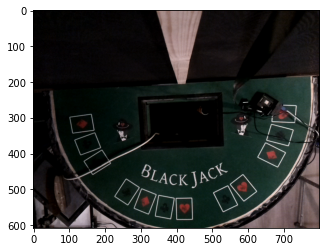

In [8]:
# Test: display a random background
_=backgrounds.get_random(display=True)

# Extraction of the cards from pictures or video 

### Define the alphamask
The alphamask has 2 purposes:
- clean the border of the detected cards,
- make that border transparent. Cards are not perfect rectangles because corners are rounded. We need to make transparent the zone between the real card and its bounding rectangle, otherwise this zone will be visible in the final generated images of the dataset


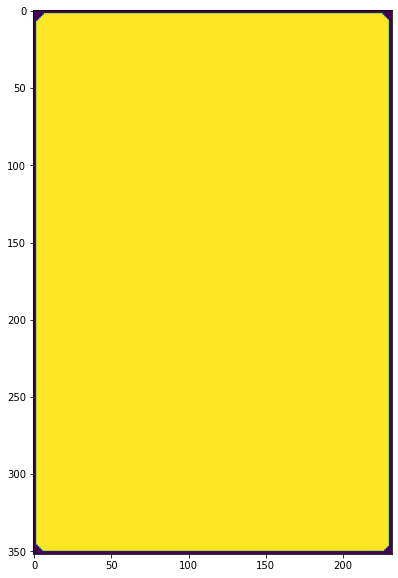

In [9]:
bord_size=2 # bord_size alpha=0
alphamask=np.ones((cardH,cardW),dtype=np.uint8)*255
cv2.rectangle(alphamask,(0,0),(cardW-1,cardH-1),0,bord_size)
cv2.line(alphamask,(bord_size*3,0),(0,bord_size*3),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,0),(cardW,bord_size*3),0,bord_size)
cv2.line(alphamask,(0,cardH-bord_size*3),(bord_size*3,cardH),0,bord_size)
cv2.line(alphamask,(cardW-bord_size*3,cardH),(cardW,cardH-bord_size*3),0,bord_size)
plt.figure(figsize=(10,10))
plt.imshow(alphamask)

## Function extract_card 
Extract from scene image (cv2/bgr) the part corresponding to the card and transforms it 
to fit into the reference card shape.
We suppose here that the user facilitates as much as he can the extraction task by
making the scene image simple (one card on uniform backgroung, not too blurry, correct lighting,...)

In [11]:
def varianceOfLaplacian(img):
    """
    Compute the Laplacian of the image and then return the focus
    measure, which is simply the variance of the Laplacian
    Source: A.Rosebrock, https://www.pyimagesearch.com/2015/09/07/blur-detection-with-opencv/
    """
    return cv2.Laplacian(img, cv2.CV_64F).var()

def extract_card (img, output_fn=None, min_focus=39, debug=False):
    """
    """
    
    imgwarp=None
    
    # Check the image is not too blurry
    focus=varianceOfLaplacian(img)
    if focus < min_focus: 
        if debug: print("Focus too low :", focus)
        return False,None
    
    # Convert in gray color
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Noise-reducing and edge-preserving filter
    gray=cv2.bilateralFilter(gray,10,10,10)
    
    # Edge extraction
    edge=cv2.Canny(gray,30,200)
    ret, bin_img  = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Find the contours in the edged image
    cnts,_ = cv2.findContours(bin_img,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    # We suppose that the contour with largest area corresponds to the contour delimiting the card
    cnt = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    
    # We want to check that 'cnt' is the contour of a rectangular shape
    # First, determine 'box', the minimum area bounding rectangle of 'cnt'
    # Then compare area of 'cnt' and area of 'box'
    # Both areas sould be very close
    rect=cv2.minAreaRect(cnt)
    box=cv2.boxPoints(rect)
    box=np.int0(box)
    areaCnt=cv2.contourArea(cnt)
    areaBox=cv2.contourArea(box)
    valid=areaCnt/areaBox>0.95
    
    if valid:
        # We want transform the zone inside the contour into the reference rectangle of dimensions (cardW,cardH)
        ((xr,yr),(wr,hr),thetar)=rect
        # Determine 'Mp' the transformation that transforms 'box' into the reference rectangle
        if wr>hr:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCard)
        else:
            Mp=cv2.getPerspectiveTransform(np.float32(box),refCardRot)
        # Determine the warped image by applying the transformation to the image
        imgwarp=cv2.warpPerspective(img,Mp,(cardW,cardH))
        # Add alpha layer
        imgwarp=cv2.cvtColor(imgwarp,cv2.COLOR_BGR2BGRA)
        
        # Shape of 'cnt' is (n,1,2), type=int with n = number of points
        # We reshape into (1,n,2), type=float32, before feeding to perspectiveTransform
        cnta=cnt.reshape(1,-1,2).astype(np.float32)
        # Apply the transformation 'Mp' to the contour
        cntwarp=cv2.perspectiveTransform(cnta,Mp)
        cntwarp=cntwarp.astype(np.int)
        
        # We build the alpha channel so that we have transparency on the
        # external border of the card
        # First, initialize alpha channel fully transparent
        alphachannel=np.zeros(imgwarp.shape[:2],dtype=np.uint8)
        # Then fill in the contour to make opaque this zone of the card 
        cv2.drawContours(alphachannel,cntwarp,0,255,-1)
        
        # Apply the alphamask onto the alpha channel to clean it
        alphachannel=cv2.bitwise_and(alphachannel,alphamask)
        
        # Add the alphachannel to the warped image
        imgwarp[:,:,3]=alphachannel
        
        # Save the image to file
        if output_fn is not None:
            cv2.imwrite(output_fn,imgwarp)
        
    if debug:
        cv2.imshow("Gray",gray)
        cv2.imshow("Canny",edge)
        edge_bgr=cv2.cvtColor(edge,cv2.COLOR_GRAY2BGR)
        cv2.drawContours(edge_bgr,[box],0,(0,0,255),3)
        cv2.drawContours(edge_bgr,[cnt],0,(0,255,0),-1)
        cv2.imshow("Contour with biggest area",edge_bgr)
        if valid:
            cv2.imshow("Alphachannel",alphachannel)
            cv2.imshow("Extracted card",imgwarp)

    return valid,imgwarp

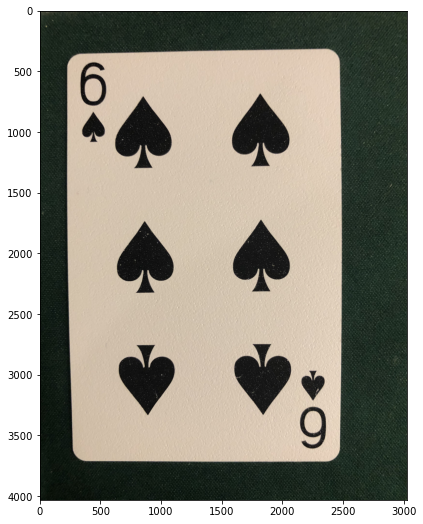

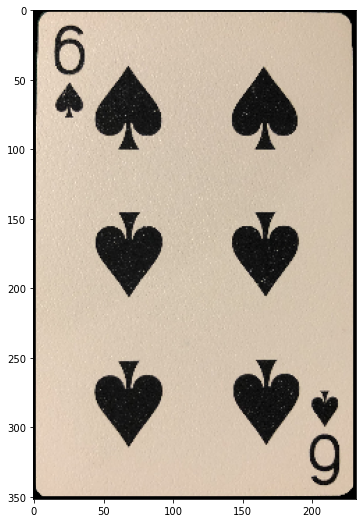

In [12]:
# Test on one image
debug=True
img=cv2.imread("data/cards_image/6s.jpeg")
display_img(img)
valid,card=extract_card(img,"data/extracted_card.png", debug=False)
if valid:
    display_img(card)
if debug:
    cv2.waitKey(0)
    cv2.destroyAllWindows()

## Function extract_cards_from_video

In [13]:
def extract_cards_from_video(video_fn, output_dir=None, keep_ratio=5, min_focus=29, debug=False):
    """
        Extract cards from media file 'video_fn' 
        If 'output_dir' is specified, the cards are saved in 'output_dir'.
        One file per card with a random file name
        Because 2 consecutives frames are probably very similar, we don't use every frame of the video, 
        but only one every 'keep_ratio' frames
        
        Returns list of extracted images
    """
    if not os.path.isfile(video_fn):
        print(f"Video file {video_fn} does not exist !!!")
        return -1,[]
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    cap=cv2.VideoCapture(video_fn)
    
    frame_nb=0
    imgs_list=[]
    while True:
        ret,img=cap.read()
        if not ret: break
        # Work on every 'keep_ratio' frames
        if frame_nb%keep_ratio==0:
            if output_dir is not None:
                output_fn=give_me_filename(output_dir,"png")
            else:
                output_fn=None
            valid,card_img = extract_card(img,output_fn,min_focus=min_focus,debug=debug)
            print(valid)
            if debug: 
                k=cv2.waitKey(1)
                if k==27: break
            if valid:
                imgs_list.append(card_img)
        frame_nb+=1
    
    if debug:
        cap.release()
        cv2.destroyAllWindows()
    
    return imgs_list
            
        
        

In [150]:
# Test card extraction from a video   
imgs=extract_cards_from_video("test/2c.avi",output_dir="test/2c",debug=True)
print("Nb images extracted:",len(imgs))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Nb images extracted: 15


# Card extraction from all the videos
We suppose we have for each card_name (ex: 2d, Kc, Ah) one video file named 'card_name.extension' (ex: 2d.avi, Kc.avi, Ah.avi) in a common directory (ex: data/video). If you use images instead of movies, the script below should work by setting the variable 'extension' below to "jpg" or "png". 
The cards from a video, or the card from an image, will be extracted in a subdirectory named 'card_name' placed in the directory 'imgs_dir' (ex: data/cards)


In [14]:
video_dir="data/cards_image"
extension="jpeg"
imgs_dir="data/cards"

for card_name in cards_values:
        
        video_fn=os.path.join(video_dir,card_name+"."+extension)
        output_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(output_dir):
            os.makedirs(output_dir)
        imgs=extract_cards_from_video(video_fn,output_dir)
        print("Extracted images for %s : %d"%(card_name,len(imgs)))

True
Extracted images for 2c : 1
True
Extracted images for 2s : 1
True
Extracted images for 4d : 1
True
Extracted images for 5d : 1
True
Extracted images for 5h : 1
True
Extracted images for 6s : 1
True
Extracted images for 7h : 1
True
Extracted images for 8c : 1
True
Extracted images for 8d : 1
True
Extracted images for 9h : 1
True
Extracted images for 10c : 1
True
Extracted images for 10s : 1


## Augment data set using imgaug

In [15]:
imgs_dir="data/cards"

seq = iaa.Sequential([
    iaa.GaussianBlur(sigma=(0, 4)), # blur images with a sigma of 0 to 2.0
])
aug = iaa.Multiply((0.5, 1.8))

for card_name in cards_values:
        img_dir=os.path.join(imgs_dir,card_name)
        img_fns=glob(img_dir+"/*.png")
        img_base=cv2.imread(img_fns[0])
        for i in range(1000):
            img_aug = aug.augment_image(seq(image=img_base))
            cv2.imwrite(img_dir+"/"+str(i)+".png",img_aug)

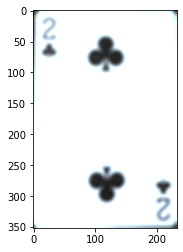

In [25]:
imgs_dir="data/cards"

card_name = "2c"
img_dir=os.path.join(imgs_dir,card_name)
img_fns=glob(img_dir+"/*.png")
img=cv2.imread(img_fns[0])
rows,cols,ch = img.shape

plt.imshow(img)
plt.show()

### Before going on, check that everything looks good
We randomly choose and display one of the extracted card. We also draw on the card the 2 polygons defined by refCornerHL and refCornerLR. Check that the value and suit symbols are well inside the polygons. If not, check the hand-made measures : cardW, cardH, cornerXmin, cornerXmax, cornerYmin and cornerYmax


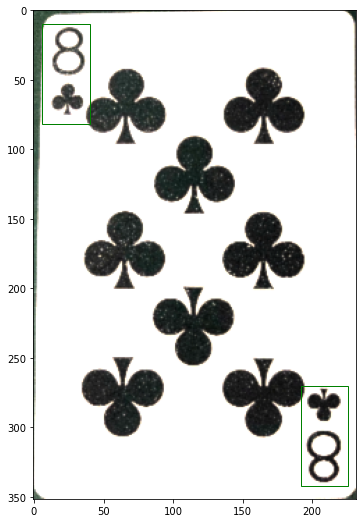

In [29]:
# Run a few times...
imgs_dir="data/cards"
imgs_fns=glob(imgs_dir+"/*/*.png")
img_fn=random.choice(imgs_fns)
display_img(cv2.imread(img_fn,cv2.IMREAD_UNCHANGED),polygons=[refCornerHL,refCornerLR])

# Finding the convex hulls
<img src="img/convex_hull.jpg" alt="Convex hull" title="Convex hull" />
This function 'find_hull' finds the convex hull in one of the corner of a card image.
The convex hull is the minimal convex polygon that contains both the value and the suit symbols. 

When I wrote this function it needed a lot of tweaking to make it work. It works well with my deck of cards, but I can't guarantee it is adapted to other decks. Search for the keyword TWEAK in the comments to find the variable and values that may need some tweak. Some of them depend on the value of global variable 'zoom'.
It may happen that the function can't find a valid convex hull for a card. It is not a problem, it only means that this card won't be used to generate the dataset.

In [32]:
def findHull(img, corner=refCornerHL, debug="no"):
    """
        Find in the zone 'corner' of image 'img' and return, the convex hull delimiting
        the value and suit symbols
        'corner' (shape (4,2)) is an array of 4 points delimiting a rectangular zone, 
        takes one of the 2 possible values : refCornerHL or refCornerLR
        debug=
    """
    
    kernel = np.ones((3,3),np.uint8)
    corner=corner.astype(np.int)

    # We will focus on the zone of 'img' delimited by 'corner'
    x1=int(corner[0][0])
    y1=int(corner[0][1])
    x2=int(corner[2][0])
    y2=int(corner[2][1])
    w=x2-x1
    h=y2-y1
    zone=img[y1:y2,x1:x2].copy()

    strange_cnt=np.zeros_like(zone)
    gray=cv2.cvtColor(zone,cv2.COLOR_BGR2GRAY)
    thld=cv2.Canny(gray,30,200)
    thld = cv2.dilate(thld,kernel,iterations=1)
    if debug!="no": cv2.imshow("thld",thld)
    
    # Find the contours
    contours,_=cv2.findContours(thld.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    min_area=30 # We will reject contours with small area. TWEAK, 'zoom' dependant
    min_solidity=0.3 # Reject contours with a low solidity. TWEAK
    
    concat_contour=None # We will aggregate in 'concat_contour' the contours that we want to keep
    
    ok=True
    for c in contours:
        area=cv2.contourArea(c)

        hull = cv2.convexHull(c)
        hull_area = cv2.contourArea(hull)
        solidity = float(area)/hull_area
        # Determine the center of gravity (cx,cy) of the contour
        M=cv2.moments(c)
        cx=int(M['m10']/M['m00'])
        cy=int(M['m01']/M['m00'])
        #  abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 : TWEAK, the idea here is to keep only the contours which are closed to the center of the zone
        if area >= min_area and abs(w/2-cx)<w*0.3 and abs(h/2-cy)<h*0.4 and solidity>min_solidity:
            if debug != "no" :
                cv2.drawContours(zone,[c],0,(255,0,0),-1)
            if concat_contour is None:
                concat_contour=c
            else:
                concat_contour=np.concatenate((concat_contour,c))
        if debug != "no" and solidity <= min_solidity :
            print("Solidity",solidity)
            cv2.drawContours(strange_cnt,[c],0,255,2)
            cv2.imshow("Strange contours",strange_cnt)
            
     
    if concat_contour is not None:
        # At this point, we suppose that 'concat_contour' contains only the contours corresponding the value and suit symbols   
        # We can now determine the hull
        hull=cv2.convexHull(concat_contour)
        hull_area=cv2.contourArea(hull)
        # If the area of the hull is to small or too big, there may be a problem
        min_hull_area=940 # TWEAK, deck and 'zoom' dependant
        max_hull_area=2120 # TWEAK, deck and 'zoom' dependant
        if hull_area < min_hull_area or hull_area > max_hull_area: 
            ok=False
            if debug!="no":
                print("Hull area=",hull_area,"too large or too small")
        # So far, the coordinates of the hull are relative to 'zone'
        # We need the coordinates relative to the image -> 'hull_in_img' 
        hull_in_img=hull+corner[0]

    else:
        ok=False
    
    
    if debug != "no" :
        if concat_contour is not None:
            cv2.drawContours(zone,[hull],0,(0,255,0),1)
            cv2.drawContours(img,[hull_in_img],0,(0,255,0),1)
        cv2.imshow("Zone",zone)
        cv2.imshow("Image",img)
        if ok and debug!="pause_always":
            key=cv2.waitKey(1)
        else:
            key=cv2.waitKey(0)
        if key==27:
            return None
    if ok == False:
        
        return None
    
    return hull_in_img

data/cards\10c\827.png


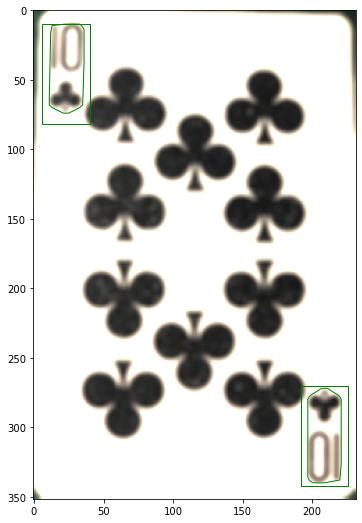

In [33]:
# Test find_hull on a random card image
# debug = "no" or "pause_always" or "pause_on_pb"
# If debug!="no", you may have to press a key to continue execution after pause
debug="no" 
imgs_dir="data/cards"
imgs_fns=glob(imgs_dir+"/*/*.png")
img_fn=random.choice(imgs_fns)
print(img_fn)
img=cv2.imread(img_fn,cv2.IMREAD_UNCHANGED)

hullHL=findHull(img,refCornerHL,debug=debug)
hullLR=findHull(img,refCornerLR,debug=debug)
display_img(img,[refCornerHL,refCornerLR,hullHL,hullLR])

if debug!="no": cv2.destroyAllWindows()

### Load all card image, calculate their convex hulls and save the whole in a pickle file (1x)

The next times, we will directly load the pickle file 
The structure saved in the pickle file is a dictionnary named 'cards' of lists of triplets (img,hullHL,hullLR). The keys of the dictionnary are the card names ("Ad","10h",... so 52 entries in the dictionnary). 

In [34]:
imgs_dir="data/cards"

cards={}
for card_name in cards_values:
        card_dir=os.path.join(imgs_dir,card_name)
        if not os.path.isdir(card_dir):
            print(f"!!! {card_dir} does not exist !!!")
            continue
        cards[card_name]=[]
        for f in glob(card_dir+"/*.png"):
            img=cv2.imread(f,cv2.IMREAD_UNCHANGED)
            hullHL=findHull(img,refCornerHL,debug="no") 
            if hullHL is None: 
                print(f"File {f} not used.")
                continue
            hullLR=findHull(img,refCornerLR,debug="no") 
            if hullLR is None: 
                print(f"File {f} not used.")
                continue
            # We store the image in "rgb" format (we don't need opencv anymore)
            img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGBA)
            cards[card_name].append((img,hullHL,hullLR))
        print(f"Nb images for {card_name} : {len(cards[card_name])}")



print("Saved in :",cards_pck_fn)
pickle.dump(cards,open(cards_pck_fn,'wb'))

cv2.destroyAllWindows()

File data/cards\2c\107.png not used.
File data/cards\2c\108.png not used.
File data/cards\2c\121.png not used.
File data/cards\2c\14.png not used.
File data/cards\2c\147.png not used.
File data/cards\2c\151.png not used.
File data/cards\2c\155.png not used.
File data/cards\2c\159.png not used.
File data/cards\2c\163.png not used.
File data/cards\2c\167.png not used.
File data/cards\2c\171.png not used.
File data/cards\2c\178.png not used.
File data/cards\2c\191.png not used.
File data/cards\2c\195.png not used.
File data/cards\2c\207.png not used.
File data/cards\2c\212.png not used.
File data/cards\2c\222.png not used.
File data/cards\2c\229.png not used.
File data/cards\2c\235.png not used.
File data/cards\2c\238.png not used.
File data/cards\2c\240.png not used.
File data/cards\2c\242.png not used.
File data/cards\2c\25.png not used.
File data/cards\2c\274.png not used.
File data/cards\2c\278.png not used.
File data/cards\2c\285.png not used.
File data/cards\2c\289.png not used.
Fil

File data/cards\2s\664.png not used.
File data/cards\2s\669.png not used.
File data/cards\2s\694.png not used.
File data/cards\2s\7.png not used.
File data/cards\2s\704.png not used.
File data/cards\2s\706.png not used.
File data/cards\2s\715.png not used.
File data/cards\2s\718.png not used.
File data/cards\2s\733.png not used.
File data/cards\2s\735.png not used.
File data/cards\2s\74.png not used.
File data/cards\2s\755.png not used.
File data/cards\2s\759.png not used.
File data/cards\2s\765.png not used.
File data/cards\2s\767.png not used.
File data/cards\2s\770.png not used.
File data/cards\2s\789.png not used.
File data/cards\2s\797.png not used.
File data/cards\2s\824.png not used.
File data/cards\2s\827.png not used.
File data/cards\2s\840.png not used.
File data/cards\2s\843.png not used.
File data/cards\2s\85.png not used.
File data/cards\2s\854.png not used.
File data/cards\2s\856.png not used.
File data/cards\2s\859.png not used.
File data/cards\2s\862.png not used.
File 

File data/cards\4d\795.png not used.
File data/cards\4d\800.png not used.
File data/cards\4d\803.png not used.
File data/cards\4d\804.png not used.
File data/cards\4d\805.png not used.
File data/cards\4d\809.png not used.
File data/cards\4d\811.png not used.
File data/cards\4d\812.png not used.
File data/cards\4d\822.png not used.
File data/cards\4d\826.png not used.
File data/cards\4d\829.png not used.
File data/cards\4d\830.png not used.
File data/cards\4d\834.png not used.
File data/cards\4d\839.png not used.
File data/cards\4d\846.png not used.
File data/cards\4d\85.png not used.
File data/cards\4d\862.png not used.
File data/cards\4d\863.png not used.
File data/cards\4d\876.png not used.
File data/cards\4d\881.png not used.
File data/cards\4d\882.png not used.
File data/cards\4d\883.png not used.
File data/cards\4d\89.png not used.
File data/cards\4d\891.png not used.
File data/cards\4d\900.png not used.
File data/cards\4d\91.png not used.
File data/cards\4d\917.png not used.
File

File data/cards\5d\517.png not used.
File data/cards\5d\518.png not used.
File data/cards\5d\524.png not used.
File data/cards\5d\529.png not used.
File data/cards\5d\531.png not used.
File data/cards\5d\532.png not used.
File data/cards\5d\534.png not used.
File data/cards\5d\535.png not used.
File data/cards\5d\537.png not used.
File data/cards\5d\541.png not used.
File data/cards\5d\542.png not used.
File data/cards\5d\544.png not used.
File data/cards\5d\547.png not used.
File data/cards\5d\548.png not used.
File data/cards\5d\550.png not used.
File data/cards\5d\553.png not used.
File data/cards\5d\555.png not used.
File data/cards\5d\558.png not used.
File data/cards\5d\559.png not used.
File data/cards\5d\560.png not used.
File data/cards\5d\561.png not used.
File data/cards\5d\565.png not used.
File data/cards\5d\566.png not used.
File data/cards\5d\571.png not used.
File data/cards\5d\574.png not used.
File data/cards\5d\576.png not used.
File data/cards\5d\58.png not used.
Fi

File data/cards\5h\151.png not used.
File data/cards\5h\154.png not used.
File data/cards\5h\156.png not used.
File data/cards\5h\157.png not used.
File data/cards\5h\16.png not used.
File data/cards\5h\162.png not used.
File data/cards\5h\164.png not used.
File data/cards\5h\169.png not used.
File data/cards\5h\173.png not used.
File data/cards\5h\174.png not used.
File data/cards\5h\178.png not used.
File data/cards\5h\179.png not used.
File data/cards\5h\18.png not used.
File data/cards\5h\181.png not used.
File data/cards\5h\183.png not used.
File data/cards\5h\185.png not used.
File data/cards\5h\187.png not used.
File data/cards\5h\19.png not used.
File data/cards\5h\194.png not used.
File data/cards\5h\196.png not used.
File data/cards\5h\2.png not used.
File data/cards\5h\20.png not used.
File data/cards\5h\200.png not used.
File data/cards\5h\201.png not used.
File data/cards\5h\202.png not used.
File data/cards\5h\207.png not used.
File data/cards\5h\208.png not used.
File da

File data/cards\5h\625.png not used.
File data/cards\5h\626.png not used.
File data/cards\5h\627.png not used.
File data/cards\5h\628.png not used.
File data/cards\5h\63.png not used.
File data/cards\5h\633.png not used.
File data/cards\5h\64.png not used.
File data/cards\5h\641.png not used.
File data/cards\5h\643.png not used.
File data/cards\5h\644.png not used.
File data/cards\5h\647.png not used.
File data/cards\5h\649.png not used.
File data/cards\5h\653.png not used.
File data/cards\5h\654.png not used.
File data/cards\5h\656.png not used.
File data/cards\5h\657.png not used.
File data/cards\5h\661.png not used.
File data/cards\5h\666.png not used.
File data/cards\5h\667.png not used.
File data/cards\5h\67.png not used.
File data/cards\5h\671.png not used.
File data/cards\5h\675.png not used.
File data/cards\5h\679.png not used.
File data/cards\5h\68.png not used.
File data/cards\5h\680.png not used.
File data/cards\5h\681.png not used.
File data/cards\5h\684.png not used.
File 

File data/cards\6s\432.png not used.
File data/cards\6s\436.png not used.
File data/cards\6s\450.png not used.
File data/cards\6s\452.png not used.
File data/cards\6s\461.png not used.
File data/cards\6s\468.png not used.
File data/cards\6s\470.png not used.
File data/cards\6s\494.png not used.
File data/cards\6s\498.png not used.
File data/cards\6s\500.png not used.
File data/cards\6s\501.png not used.
File data/cards\6s\504.png not used.
File data/cards\6s\537.png not used.
File data/cards\6s\553.png not used.
File data/cards\6s\564.png not used.
File data/cards\6s\568.png not used.
File data/cards\6s\577.png not used.
File data/cards\6s\578.png not used.
File data/cards\6s\579.png not used.
File data/cards\6s\591.png not used.
File data/cards\6s\593.png not used.
File data/cards\6s\596.png not used.
File data/cards\6s\616.png not used.
File data/cards\6s\617.png not used.
File data/cards\6s\631.png not used.
File data/cards\6s\633.png not used.
File data/cards\6s\635.png not used.
F

File data/cards\7h\488.png not used.
File data/cards\7h\490.png not used.
File data/cards\7h\492.png not used.
File data/cards\7h\493.png not used.
File data/cards\7h\495.png not used.
File data/cards\7h\509.png not used.
File data/cards\7h\510.png not used.
File data/cards\7h\511.png not used.
File data/cards\7h\513.png not used.
File data/cards\7h\515.png not used.
File data/cards\7h\517.png not used.
File data/cards\7h\521.png not used.
File data/cards\7h\522.png not used.
File data/cards\7h\53.png not used.
File data/cards\7h\537.png not used.
File data/cards\7h\539.png not used.
File data/cards\7h\540.png not used.
File data/cards\7h\543.png not used.
File data/cards\7h\546.png not used.
File data/cards\7h\547.png not used.
File data/cards\7h\549.png not used.
File data/cards\7h\554.png not used.
File data/cards\7h\555.png not used.
File data/cards\7h\557.png not used.
File data/cards\7h\559.png not used.
File data/cards\7h\560.png not used.
File data/cards\7h\561.png not used.
Fi

File data/cards\8c\427.png not used.
File data/cards\8c\439.png not used.
File data/cards\8c\441.png not used.
File data/cards\8c\444.png not used.
File data/cards\8c\450.png not used.
File data/cards\8c\453.png not used.
File data/cards\8c\457.png not used.
File data/cards\8c\460.png not used.
File data/cards\8c\462.png not used.
File data/cards\8c\498.png not used.
File data/cards\8c\50.png not used.
File data/cards\8c\508.png not used.
File data/cards\8c\518.png not used.
File data/cards\8c\520.png not used.
File data/cards\8c\522.png not used.
File data/cards\8c\523.png not used.
File data/cards\8c\529.png not used.
File data/cards\8c\532.png not used.
File data/cards\8c\536.png not used.
File data/cards\8c\538.png not used.
File data/cards\8c\541.png not used.
File data/cards\8c\559.png not used.
File data/cards\8c\560.png not used.
File data/cards\8c\578.png not used.
File data/cards\8c\579.png not used.
File data/cards\8c\594.png not used.
File data/cards\8c\602.png not used.
Fi

File data/cards\8d\383.png not used.
File data/cards\8d\388.png not used.
File data/cards\8d\389.png not used.
File data/cards\8d\39.png not used.
File data/cards\8d\390.png not used.
File data/cards\8d\391.png not used.
File data/cards\8d\393.png not used.
File data/cards\8d\395.png not used.
File data/cards\8d\396.png not used.
File data/cards\8d\404.png not used.
File data/cards\8d\405.png not used.
File data/cards\8d\406.png not used.
File data/cards\8d\409.png not used.
File data/cards\8d\41.png not used.
File data/cards\8d\410.png not used.
File data/cards\8d\412.png not used.
File data/cards\8d\415.png not used.
File data/cards\8d\416.png not used.
File data/cards\8d\42.png not used.
File data/cards\8d\420.png not used.
File data/cards\8d\424.png not used.
File data/cards\8d\426.png not used.
File data/cards\8d\428.png not used.
File data/cards\8d\429.png not used.
File data/cards\8d\431.png not used.
File data/cards\8d\432.png not used.
File data/cards\8d\434.png not used.
File

File data/cards\8d\841.png not used.
File data/cards\8d\845.png not used.
File data/cards\8d\847.png not used.
File data/cards\8d\848.png not used.
File data/cards\8d\85.png not used.
File data/cards\8d\851.png not used.
File data/cards\8d\858.png not used.
File data/cards\8d\859.png not used.
File data/cards\8d\860.png not used.
File data/cards\8d\861.png not used.
File data/cards\8d\862.png not used.
File data/cards\8d\863.png not used.
File data/cards\8d\866.png not used.
File data/cards\8d\867.png not used.
File data/cards\8d\869.png not used.
File data/cards\8d\871.png not used.
File data/cards\8d\872.png not used.
File data/cards\8d\874.png not used.
File data/cards\8d\876.png not used.
File data/cards\8d\882.png not used.
File data/cards\8d\884.png not used.
File data/cards\8d\886.png not used.
File data/cards\8d\889.png not used.
File data/cards\8d\890.png not used.
File data/cards\8d\891.png not used.
File data/cards\8d\897.png not used.
File data/cards\8d\898.png not used.
Fi

File data/cards\9h\567.png not used.
File data/cards\9h\569.png not used.
File data/cards\9h\573.png not used.
File data/cards\9h\576.png not used.
File data/cards\9h\577.png not used.
File data/cards\9h\581.png not used.
File data/cards\9h\585.png not used.
File data/cards\9h\587.png not used.
File data/cards\9h\599.png not used.
File data/cards\9h\610.png not used.
File data/cards\9h\611.png not used.
File data/cards\9h\612.png not used.
File data/cards\9h\616.png not used.
File data/cards\9h\617.png not used.
File data/cards\9h\623.png not used.
File data/cards\9h\625.png not used.
File data/cards\9h\628.png not used.
File data/cards\9h\629.png not used.
File data/cards\9h\63.png not used.
File data/cards\9h\630.png not used.
File data/cards\9h\631.png not used.
File data/cards\9h\635.png not used.
File data/cards\9h\637.png not used.
File data/cards\9h\645.png not used.
File data/cards\9h\646.png not used.
File data/cards\9h\649.png not used.
File data/cards\9h\651.png not used.
Fi

File data/cards\10c\594.png not used.
File data/cards\10c\6.png not used.
File data/cards\10c\601.png not used.
File data/cards\10c\602.png not used.
File data/cards\10c\606.png not used.
File data/cards\10c\609.png not used.
File data/cards\10c\62.png not used.
File data/cards\10c\620.png not used.
File data/cards\10c\623.png not used.
File data/cards\10c\629.png not used.
File data/cards\10c\63.png not used.
File data/cards\10c\640.png not used.
File data/cards\10c\644.png not used.
File data/cards\10c\649.png not used.
File data/cards\10c\657.png not used.
File data/cards\10c\659.png not used.
File data/cards\10c\661.png not used.
File data/cards\10c\693.png not used.
File data/cards\10c\706.png not used.
File data/cards\10c\707.png not used.
File data/cards\10c\718.png not used.
File data/cards\10c\72.png not used.
File data/cards\10c\732.png not used.
File data/cards\10c\744.png not used.
File data/cards\10c\750.png not used.
File data/cards\10c\758.png not used.
File data/cards\1

File data/cards\10s\566.png not used.
File data/cards\10s\567.png not used.
File data/cards\10s\572.png not used.
File data/cards\10s\574.png not used.
File data/cards\10s\576.png not used.
File data/cards\10s\577.png not used.
File data/cards\10s\578.png not used.
File data/cards\10s\579.png not used.
File data/cards\10s\586.png not used.
File data/cards\10s\590.png not used.
File data/cards\10s\592.png not used.
File data/cards\10s\598.png not used.
File data/cards\10s\599.png not used.
File data/cards\10s\613.png not used.
File data/cards\10s\62.png not used.
File data/cards\10s\622.png not used.
File data/cards\10s\623.png not used.
File data/cards\10s\63.png not used.
File data/cards\10s\630.png not used.
File data/cards\10s\634.png not used.
File data/cards\10s\635.png not used.
File data/cards\10s\638.png not used.
File data/cards\10s\642.png not used.
File data/cards\10s\647.png not used.
File data/cards\10s\651.png not used.
File data/cards\10s\654.png not used.
File data/card

### Load the cards pickle file in 'cards'
'cards' is an instance of the class Cards
To get a random background image, call the method : cards.get_random() or cards.get_random(card_name) if you want a random card of a given value. Ex: cards.get_random('Ah')

In [35]:
class Cards():
    def __init__(self,cards_pck_fn=cards_pck_fn):
        self._cards=pickle.load(open(cards_pck_fn,'rb'))
        # self._cards is a dictionary where keys are card names (ex:'Kc') and values are lists of (img,hullHL,hullLR) 
        self._nb_cards_by_value={k:len(self._cards[k]) for k in self._cards}
        print("Nb of cards loaded per name :", self._nb_cards_by_value)
        
    def get_random(self, card_name=None, display=False):
        if card_name is None:
            card_name= random.choice(list(self._cards.keys()))
        card,hull1,hull2=self._cards[card_name][random.randint(0,self._nb_cards_by_value[card_name]-1)]
        if display:
            display_img(card,[hull1,hull2],"rgb")
        return card,card_name,hull1,hull2
    
cards = Cards()


Nb of cards loaded per name : {'2c': 876, '2s': 861, '4d': 775, '5d': 607, '5h': 577, '6s': 865, '7h': 676, '8c': 876, '8d': 553, '9h': 724, '10c': 838, '10s': 749}


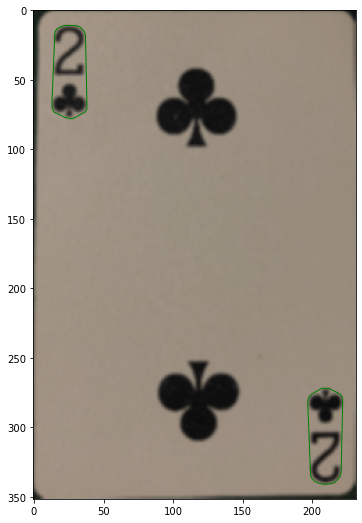

In [43]:
# Test: display a random card
_=cards.get_random(display=True)
# Display a random Ace of spades
#_=cards.get_random("As",display=True)

# Generating a scene
We can now generate a scene (= image of the dataset). We are considering here only 2 kinds of scene (but nothing prevents you to add more scenarios):
1. a scene with 2 cards: each card is randomly transformed (scaled, rotated, translated) independantly from the other;
2. a scene with 3 cards : the 3 cards are grouped together (a bit randomly) to form a fan, then the group is randomly transformed.

|   |   |
|---|---|
|<img src="img/gen_2_cards.jpg" alt="Generated image with 2 cards" title="Generated image with 2 cards" />|<img src="img/gen_3_cards.jpg" alt="Generated image with 3 cards" title="Generated image with 3 cards" />|

### To save bounding boxes annotations in Pascal VOC format 
http://host.robots.ox.ac.uk/pascal/VOC/voc2008/htmldoc/

In [44]:
xml_body_1="""<annotation>
        <folder>FOLDER</folder>
        <filename>{FILENAME}</filename>
        <path>{PATH}</path>
        <source>
                <database>Unknown</database>
        </source>
        <size>
                <width>{WIDTH}</width>
                <height>{HEIGHT}</height>
                <depth>3</depth>
        </size>
"""
xml_object=""" <object>
                <name>{CLASS}</name>
                <pose>Unspecified</pose>
                <truncated>0</truncated>
                <difficult>0</difficult>
                <bndbox>
                        <xmin>{XMIN}</xmin>
                        <ymin>{YMIN}</ymin>
                        <xmax>{XMAX}</xmax>
                        <ymax>{YMAX}</ymax>
                </bndbox>
        </object>
"""
xml_body_2="""</annotation>        
"""

def create_voc_xml(xml_file, img_file,listbba,display=False):
    with open(xml_file,"w") as f:
        f.write(xml_body_1.format(**{'FILENAME':os.path.basename(img_file), 'PATH':img_file,'WIDTH':imgW,'HEIGHT':imgH}))
        for bba in listbba:            
            f.write(xml_object.format(**{'CLASS':bba.classname,'XMIN':bba.x1,'YMIN':bba.y1,'XMAX':bba.x2,'YMAX':bba.y2}))
        f.write(xml_body_2)
        if display: print("New xml",xml_file)
        


In [45]:

# Scenario with 2 cards:
# The original image of a card has the shape (cardH,cardW,4)
# We first paste it in a zero image of shape (imgH,imgW,4) at position decalX, decalY
# so that the original image is centerd in the zero image
decalX=int((imgW-cardW)/2)
decalY=int((imgH-cardH)/2)

# Scenario with 3 cards : decal values are different
decalX3=int(imgW/2)
decalY3=int(imgH/2-cardH)

def kps_to_polygon(kps):
    """
        Convert imgaug keypoints to shapely polygon
    """
    pts=[(kp.x,kp.y) for kp in kps]
    return Polygon(pts)

def hull_to_kps(hull, decalX=decalX, decalY=decalY):
    """
        Convert hull to imgaug keypoints
    """
    # hull is a cv2.Contour, shape : Nx1x2
    kps=[ia.Keypoint(x=p[0]+decalX,y=p[1]+decalY) for p in hull.reshape(-1,2)]
    kps=ia.KeypointsOnImage(kps, shape=(imgH,imgW,3))
    return kps

def kps_to_BB(kps):
    """
        Determine imgaug bounding box from imgaug keypoints
    """
    extend=3 # To make the bounding box a little bit bigger
    kpsx=[kp.x for kp in kps.keypoints]
    minx=max(0,int(min(kpsx)-extend))
    maxx=min(imgW,int(max(kpsx)+extend))
    kpsy=[kp.y for kp in kps.keypoints]
    miny=max(0,int(min(kpsy)-extend))
    maxy=min(imgH,int(max(kpsy)+extend))
    if minx==maxx or miny==maxy:
        return None
    else:
        return ia.BoundingBox(x1=minx,y1=miny,x2=maxx,y2=maxy)


# imgaug keypoints of the bounding box of a whole card
cardKP = ia.KeypointsOnImage([
    ia.Keypoint(x=decalX,y=decalY),
    ia.Keypoint(x=decalX+cardW,y=decalY),   
    ia.Keypoint(x=decalX+cardW,y=decalY+cardH),
    ia.Keypoint(x=decalX,y=decalY+cardH)
    ], shape=(imgH,imgW,3))

# imgaug transformation for one card in scenario with 2 cards
transform_1card = iaa.Sequential([
    iaa.Affine(scale=[0.2,0.2]),
    iaa.Affine(rotate=(-180,180)),
    iaa.Affine(translate_percent={"x":(-0.25,0.25),"y":(-0.25,0.25)}),
])


# imgaug transformation for the background
scaleBg=iaa.Scale({"height": imgH, "width": imgW})

def augment(img, list_kps, seq, restart=True):
    """
        Apply augmentation 'seq' to image 'img' and keypoints 'list_kps'
        If restart is False, the augmentation has been made deterministic outside the function (used for 3 cards scenario)
    """ 
    # Make sequence deterministic
    while True:
        if restart:
            myseq=seq.to_deterministic()
        else:
            myseq=seq
        # Augment image, keypoints and bbs 
        img_aug = myseq.augment_images([img])[0]
        list_kps_aug = [myseq.augment_keypoints([kp])[0] for kp in list_kps]
        list_bbs = [kps_to_BB(list_kps_aug[1]),kps_to_BB(list_kps_aug[2])]
        valid=True
        # Check the card bounding box stays inside the image
        for bb in list_bbs:
            if bb is None or int(round(bb.x2)) >= imgW or int(round(bb.y2)) >= imgH or int(bb.x1)<=0 or int(bb.y1)<=230:
                valid=False
                break
        if valid: break
        elif not restart:
            img_aug=None
            break
                
    return img_aug,list_kps_aug,list_bbs

class BBA:  # Bounding box + annotations
    def __init__(self,bb,classname):      
        self.x1=int(round(bb.x1))
        self.y1=int(round(bb.y1))
        self.x2=int(round(bb.x2))
        self.y2=int(round(bb.y2))
        self.classname=classname
class Scene:
    def __init__(self,bg,L):
        self.listbba=[]
        transformed_images = []
        hulls_of_cards = []
        #set bg to uint if in float mode
        if (bg.dtype != "uint8"):
            bg = (bg*255).astype("uint8")

        for (img,classnb,hulla,hullb) in L: 
            
            kpsa=hull_to_kps(hulla)
            kpsb=hull_to_kps(hullb)
            #Randomly transform card. We want that card does not partially cover a corner of another card.
            # If so, we apply a new random transform to card
            while True:
                t_img=np.zeros((imgH,imgW,4),dtype=np.uint8)
                t_img[decalY:decalY+cardH,decalX:decalX+cardW,:]=img
                t_img,lkps,bbs=augment(t_img,[cardKP,kpsa,kpsb],transform_1card)
                
                mainPoly=kps_to_polygon(lkps[0].keypoints[0:4])
                valid=True
                intersect_ratio=0.1
                for smallPoly in hulls_of_cards:
                    # smallPoly1: shapely polygon of one of the hull of another card
                    a=smallPoly.area
                    # We calculate area of the intersection of card 1 corner with card 2
                    intersect=mainPoly.intersection(smallPoly)
                    ai=intersect.area
                    # If intersectio area is not small, but also not big enough, we want apply new transform to card 2
                    if 1-intersect_ratio> (a-ai)/a:
                        valid=False
                        break
                if valid: break
            for i in range(1,3):
                hulls_of_cards.append(kps_to_polygon(lkps[i].keypoints[:]))
            for bb in bbs:
                self.listbba.append(BBA(bb,classnb))
            transformed_images.append(t_img)
        
        # Construct final image of the scene by superimposing bg and transformed card images
        for i,img in enumerate(transformed_images):
            mask=np.stack([img[:,:,3]]*3,-1)
            if (i == 0):
                self.final=np.where(mask,img[:,:,0:3],scaleBg.augment_image(bg))
            else:
                self.final=np.where(mask,img[:,:,0:3],self.final)
                
    def display(self):
        fig,ax=plt.subplots(1,figsize=(8,8))
        ax.imshow(self.final)
        for bb in self.listbba:
            rect=patches.Rectangle((bb.x1,bb.y1),bb.x2-bb.x1,bb.y2-bb.y1,linewidth=1,edgecolor='b',facecolor='none')
            ax.add_patch(rect)
    def res(self):
        return self.final
    def write_files(self,save_dir,display=False):
        jpg_fn, xml_fn=give_me_filename(save_dir, ["jpg","xml"])
        plt.imsave(jpg_fn,self.final)
        if display: print("New image saved in",jpg_fn)
        create_voc_xml(xml_fn,jpg_fn, self.listbba,display=display)

#function to generate N cards with different values (N should be in [0;12])
def generate_N_cards(N):
    assert N<=len(cards_values)
    indexes_left = [i for i in range(len(cards_values))]
    L = []
    for i in range(N):
        index = np.random.choice(indexes_left)
        L.append(cards.get_random(card_name=cards_values[index]))
        indexes_left.remove(index)
    return L

C:\Users\ugobe\Anaconda3\envs\cv\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `Scale()` is deprecated. Use `Resize` instead. Resize has the exactly same interface as Scale.
  warn_deprecated(msg, stacklevel=3)


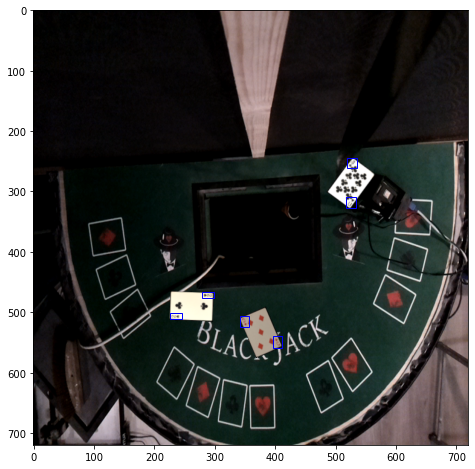

In [50]:
bg=backgrounds.get_random()
N_CARDS = 12
L = generate_N_cards(3)

newimg=Scene(bg,L)
newimg.display()

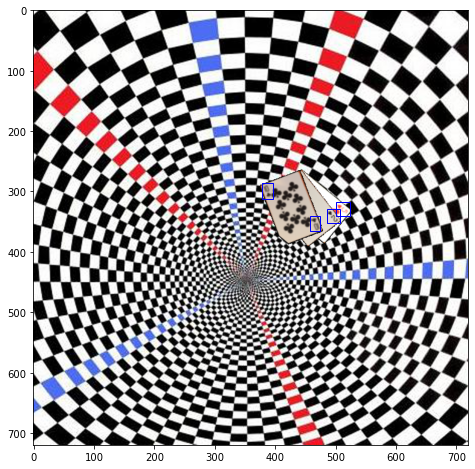

In [128]:
# Test generation of a scene with 3 cards
bg=backgrounds.get_random()
img1,card_val1,hulla1,hullb1=cards.get_random()
img2,card_val2,hulla2,hullb2=cards.get_random()
img3,card_val3,hulla3,hullb3=cards.get_random()

newimg=Scene(bg,img1,card_val1,hulla1,hullb1,img2,card_val2,hulla2,hullb2,img3,card_val3,hulla3,hullb3)
newimg.display()

## Generate the datasets
Typically, you want to generate a training dataset and a validation dataset of different size and different destination directory.
Modify the variable 'nb_cards_to_generate' and 'save_dir' accordingly


### Generation of the train set

In [51]:
nb_cards_to_generate=2000
save_dir="data/scenes/train"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    for N_cards in range(2,13):
        bg=backgrounds.get_random()
        L = generate_N_cards(N_cards)
        newimg=Scene(bg,L)
        newimg.write_files(save_dir)

100%|████████████████████████████████████████████████████████████████████████████| 2000/2000 [3:29:52<00:00,  6.30s/it]


### Generation of the val set

In [52]:
nb_cards_to_generate=200
save_dir="data/scenes/val"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    for N_cards in range(2,13):
        bg=backgrounds.get_random()
        L = generate_N_cards(N_cards)
        newimg=Scene(bg,L)
        newimg.write_files(save_dir)

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [21:17<00:00,  6.39s/it]


## Generation of the test set

In [ ]:
nb_cards_to_generate=80
save_dir="data/scenes/test"

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

for i in tqdm(range(nb_cards_to_generate)):
    for N_cards in range(2,13):
        bg=backgrounds.get_random()
        L = generate_N_cards(N_CARDS)
        newimg=Scene(bg,L)
        newimg.write_files(save_dir)

## In case you want to train YOLO with the generated datasets
YOLO cannot directly exploit the Pascal VOC annotations files. You need to convert the xml files in txt files accordingly to the syntax explained here: https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects
The script 'convert_voc_yolo.py' makes this conversion and also generates the txt file that contains all the images of the dataset

In [53]:
!python convert_voc_yolo.py data/scenes/val data/cards.names data/val.txt
!python convert_voc_yolo.py data/scenes/train data/cards.names data/train.txt

['2c', '2s', '4d', '5d', '5h', '6s', '7h', '8c', '8d', '9h', '10c', '10s'] 12
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
['2c', '2s', '4d', '5d', '5h', '6s', '7h', '8c', '8d', '9h', '10c', '10s'] 12
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
1

## Modify train.txt and val.txt from windows path to linux path

In [54]:
train = open("data/train.txt","r")
new_train = open("data/new_train.txt","w")
lines = train.readlines()
for line in lines:
    new_line = line[:17] + "/" + line[18:]
    new_train.write(new_line)

train.close()
new_train.close()

val = open("data/val.txt","r")
new_val = open("data/new_val.txt","w")
lines = val.readlines()
for line in lines:
    new_line = line[:15] + "/" + line[16:]
    new_val.write(new_line)

val.close()
new_val.close()

16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18500
18600
18700
18800
18900
19000
19100
19200
19300
19400
19500
19600
19700
19800
19900
20000
20100
20200
20300
20400
20500
20600
20700
20800
20900
21000
21100
21200
21300
21400
21500
21600
21700
21800
21900
22000
22100
22200
22300
22400
22500
22600
22700
22800
22900
23000
23100
23200
23300
23400
23500
23600
23700
23800
23900
24000
24100
24200
24300
24400
24500
24600
24700
24800
24900
25000
25100
25200
25300
25400
25500
25600
25700
25800
25900
26000
26100
26200
26300
26400
26500
26600
26700
26800
26900
27000
27100
27200
27300
27400
27500
27600
27700
27800
27900
28000
28100
28200
28300
28400
28500
28600
28700
28800
28900
29000
29100
29200
29300
29400
29500
29600
29700
29800
29900
30000
30100
30200
30300
30400
30500
30600
30700
